In [164]:
# import labraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import norm

In [166]:
#black-scholes functions
def bs_call_price(S,K,T,r,sigma):
    if T<=0:
        return max(S-K,0)
    d1=(np.log(S/K)+(r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2=d1 - sigma**np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def bs_delta(S,K,T,r,sigma):
    if T<=0:
        return 1.0 if S>K else 0.0
    d1=(np.log(S/K)+(r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    return norm.cdf(d1)

def bs_gamma(S,K,T,r,sigma):
    if T<=0:
        return 0.0
    d1=(np.log(S/K)+(r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    return norm.pdf(d1)/(S*sigma*np.sqrt(T))
    
    


In [180]:
#data download
#ticker="^NSEI"
#data=yf.download(ticker,start="2022-01-01",end="2024-01-01")
#prices=data["Close"].dropna().values

#parameter
np.random.seed(42)
days=60
S0=100
K=S0 # ATM option
r=0.01       # risk-free rate
sigma_impl=0.20 # implied volatility
sigma_real=0.2
dt=1/252
mu=0.0
tcost=0.001    # transactuion cost

prices=[S0]
for _ in range(days):
    prices.append(
        prices[-1]* np.exp(
            (mu-0.5*sigma_real**2)*dt +
            sigma_real * np.sqrt(dt)* np.random.randn()
        )
    )
prices=np.array(prices)



In [190]:
# storage
option_values=[]
deltas=[]
gammas=[]
hedge_positions=[]
cash=0

# GAMMA scalping loop
for i in range(len(prices)):
    T_remain=max((days-i)/252, 1e-6)
    S=prices[i]
    
    price=bs_call_price(S,K,T_remain,r,sigma_impl)
    delta=bs_delta(S,K,T_remain,r,sigma_impl)
    gamma=bs_gamma(S,K,T_remain,r,sigma_impl)
    
    option_values.append(price)
    deltas.append(delta)
    gammas.append(gamma)
    hedge_positions.append(-delta)
  

In [192]:
#dataframe
df_out = pd.DataFrame({
    "price": prices[:n],
    "option_value": option_values[:n],
    "delta": deltas[:n],
    "gamma": gammas[:n],
    "hedge_position": hedge_positions[:n]
})
df_out["option_pnl"] = df_out["option_value"].diff()
df_out["hedge_pnl"] = df_out["hedge_position"].shift(1) * df_out["price"].diff()
df_out["total_pnl"] = df_out["option_pnl"] + df_out["hedge_pnl"]
df_out["cum_pnl"] = df_out["total_pnl"].cumsum()

df_out = df_out.dropna()

In [194]:
# convert to numpy
option_values=np.array(option_values)
deltas=np.array(deltas)
gammas=np.array(gammas)
hedge_positions=np.array(hedge_positions)
prices=np.array(prices)

In [198]:
# P&L calculation
ds=prices[1:] - prices[:-1]
#option_pnl=option_pnl[:min_len]
option_pnl=option_values[1:]-option_values[:-1]
hedge_used=hedge_positions[:-1]
n=min(len(ds), len(option_pnl), len(hedge_used))
ds=ds[:n]
option_pnl=option_pnl[:n]
hedge_used=hedge_used[:n]
hedge_pnl=hedge_used * ds

total_pnl=option_pnl + hedge_pnl
cum_pnl=np.cumsum(total_pnl)
print("Mean daily Pnl:",np.mean(total_pnl))
print("Std of daily Pnl:",np.std(total_pnl))
print("Max Drawdown:",np.min(cum_pnl))



Mean daily Pnl: -0.23429007785291642
Std of daily Pnl: 1.1278871327322653
Max Drawdown: -14.057404671174984


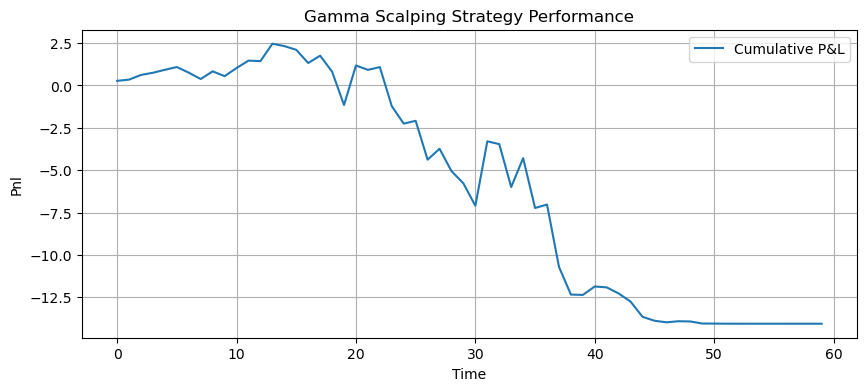

In [200]:
#plots
plt.figure(figsize=(10,4))
plt.plot(cum_pnl,label="Cumulative P&L")
plt.title("Gamma Scalping Strategy Performance")
plt.xlabel("Time")
plt.ylabel("Pnl")
plt.legend()
plt.grid(True)
plt.show()

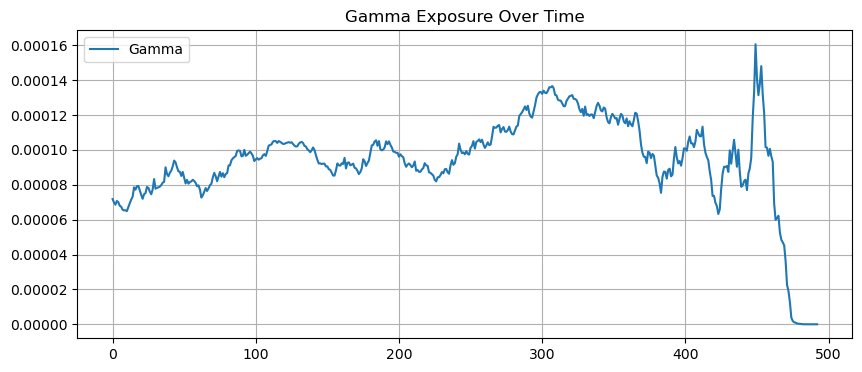

Final Cumulative Pnl: 3.431821140187827
Transaction Cost Impact: [94.99454436]


In [132]:
#plots
plt.figure(figsize=(10,4))
plt.plot(gammas,label="Gamma")
plt.title("Gamma Exposure Over Time")
plt.legend()
plt.grid(True)
plt.show()

print("Final Cumulative Pnl:",cum_pnl[-1])
print("Transaction Cost Impact:",-cash)

In [202]:
df_out.to_csv("gamma_reactor_output.csv",index=False)
print("CSV file saved: gamma_reactor_output.csv")

CSV file saved: gamma_reactor_output.csv
